In [1]:
%matplotlib inline
import matplotlib.image as mpimg
from statsmodels.api import Logit
import glob
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import cv2
import joblib

In [2]:
paraTrain = glob.glob("Data/training_set/Parasitized/*")
noParaTrain = glob.glob("Data/training_set/Uninfected/*")
paraTest = glob.glob("Data/testing_set/Parasitized/*")
noParaTest = glob.glob("Data/testing_set/Uninfected/*")
paraValid = glob.glob("Data/validation_set/Parasitized/*")
noParaValid = glob.glob("Data/validation_set/Uninfected/*")

In [3]:
trainSize = 400
paraTrainIndexes = np.random.randint(len(paraTrain), size=trainSize)
paraTrain = [mpimg.imread(paraTrain[i]) for i in paraTrainIndexes]
noParaTrainIndexes = np.random.randint(len(noParaTrain), size=trainSize)
noParaTrain = [mpimg.imread(noParaTrain[i]) for i in noParaTrainIndexes]
trainData = paraTrain + noParaTrain
trainLabels = [True]*trainSize + [False]*trainSize

validSize = 80
paraValidIndexes = np.random.randint(len(paraValid), size=validSize)
paraValid = [mpimg.imread(paraValid[i]) for i in paraValidIndexes]
noParaValidIndexes = np.random.randint(len(noParaValid), size=validSize)
noParaValid = [mpimg.imread(noParaValid[i]) for i in noParaValidIndexes]
validData = paraValid + noParaValid
validLabels = [True]*validSize + [False]*validSize

testSize = 80
paraTestIndexes = np.random.randint(len(paraTest), size=testSize)
paraTest = [mpimg.imread(paraTest[i]) for i in paraTestIndexes]
noParaTestIndexes = np.random.randint(len(noParaTest), size=testSize)
noParaTest = [mpimg.imread(noParaTest[i]) for i in noParaTestIndexes]
testData = paraTest + noParaTest
testLabels = [True]*testSize + [False]*testSize

In [4]:
trainHist = []
for i in trainData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    trainHist.append(np.histogram(flatImage, bins=20)
                     [0]/float(len(flatImage)))

validHist = []
for i in validData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    validHist.append(np.histogram(flatImage, bins=20)
                    [0]/float(len(flatImage)))

testHist = []
for i in testData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    testHist.append(np.histogram(flatImage, bins=20)
                    [0]/float(len(flatImage)))

In [5]:
logitModel = Logit(trainLabels, trainHist).fit()
pscore_logit = logitModel.predict(validHist)
joblib.dump(logitModel,'Models/logit_res.pkl')
logitModel.summary()

Optimization terminated successfully.
         Current function value: 0.241260
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      780
Method:                           MLE   Df Model:                           19
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                  0.6519
Time:                        11:47:52   Log-Likelihood:                -193.01
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                4.742e-141
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.8625     30.792     -0.125      0.900     -64.214      56.489
x2            -6.2112      7.631     -0.814      0.416     -21.168       8.746
x3            -1.0379      6.891     -0.151      0.880     -14.545      12.469
x4           -17.3314      8.740     -1.983      0.047     -34.462      -0.201
x5           -14.5901      7.723     -1.889      0.059     -29.726       0.546
x6             7.4467      5.513      1.351      0.177      -3.359      18.252
x7           -18.2796      5.828     -3.137      0.002     -29.702      -6.857
x8             0.9865      4.692      0.210      0.833      -8.210      10.184
x9            -2.8561      2.555     -1.118      0.264      -7.864       2.152
x10           -1.5051      3.313     -0.454      0.650      -7.998       4.987
x11           -3.2325      2.633     -1.228      0.220      -8.394       1.929
x12            6.1167      2.431      2.516      0.012       1.353      10.881
x13            3.1017      1.762      1.760      0.078      -0.351       6.555
x14            0.7635      1.613      0.473      0.636      -2.399       3.926
x15            0.8614      2.036      0.423      0.672      -3.130       4.853
x16            0.4089      1.892      0.216      0.829      -3.300       4.118
x17            1.6617      1.821      0.913      0.361      -1.907       5.230
x18            7.4851      2.081      3.596      0.000       3.406      11.565
x19            6.1112      2.831      2.159      0.031       0.562      11.660
x20            6.7942      7.041      0.965      0.335      -7.005      20.594
==============================================================================
"""

In [6]:
pscore_knn = None
max_kscore_knn = 0
knnModel = None
for i in range(1, 22, 2):
    knnClas = KNeighborsClassifier(n_neighbors=i)
    knnClas.fit(trainHist, trainLabels)
    temp_pscore_knn = knnClas.predict_proba(validHist)
    fscore_knn = f1_score(testLabels, temp_pscore_knn[:, 1] > 0.5)
    if fscore_knn > max_kscore_knn:
        max_fscore_knn = fscore_knn
        pscore_knn = temp_pscore_knn
        knnModel = knnClas
joblib.dump(knnModel, 'Models/knnClas.pkl')

['Models/knnClas.pkl']

In [7]:
criterion = 'gini' #gini or entropy
max_features = 'sqrt' #sqrt || log2 || None
max_depth = None
randomForestClas = RandomForestClassifier(n_estimators=100,criterion=criterion,max_features=max_features,max_depth=max_depth)
randomForestClas.fit(trainHist, trainLabels)
pscore_forest = randomForestClas.predict_proba(validHist)
joblib.dump(randomForestClas, 'Models/randomForestClas.pkl')

['Models/randomForestClas.pkl']

-------------------->ROC<--------------------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.985
Random Forest: ROC AUC=0.990
KNN: ROC AUC=0.986
-------------------->Precision-Recall<--------------------
No Skill: Precision-Recall AUC=0.500
Logistic: Precision-Recall AUC=0.986
Random Forest: Precision-Recall AUC=0.991
KNN: Precision-Recall AUC=0.986


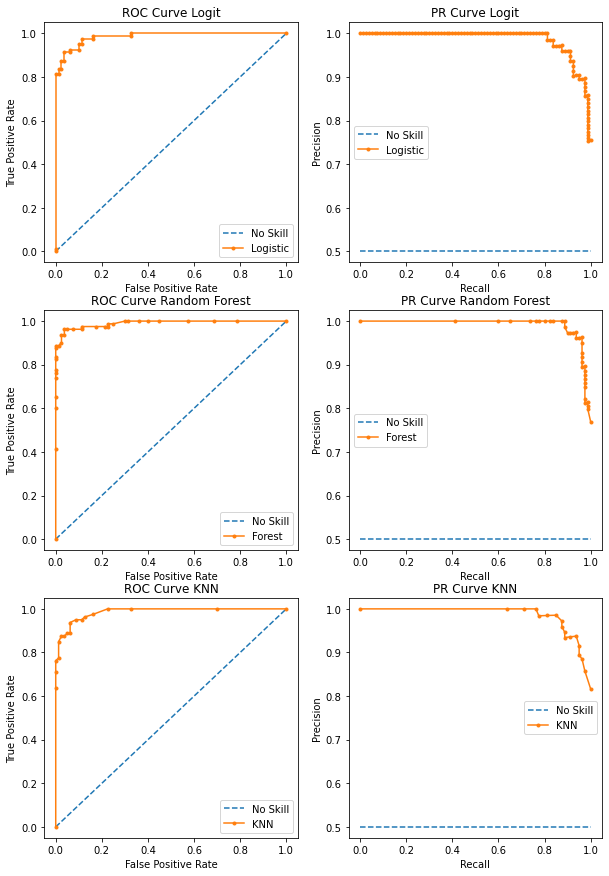

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# generate a no skill prediction
ns_probs = [0 for _ in range(len(testLabels))]
no_skill = np.count_nonzero(testLabels) / len(testLabels)

# calculate curves
ns_fpr, ns_tpr, _ = roc_curve(testLabels, ns_probs)
logit_fpr, logit_tpr, _ = roc_curve(testLabels, pscore_logit)
forest_fpr, forest_tpr, _ = roc_curve(testLabels, pscore_forest[:, 1])
knn_fpr, knn_tpr, _ = roc_curve(testLabels, pscore_knn[:, 1])

ns_precision, ns_recall, _ = precision_recall_curve(testLabels, ns_probs)
logit_precision, logit_recall, _ = precision_recall_curve(
    testLabels, pscore_logit)
forest_precision, forest_recall, _ = precision_recall_curve(
    testLabels, pscore_forest[:, 1])
knn_precision, knn_recall, _ = precision_recall_curve(
    testLabels, pscore_knn[:, 1])


# calculate scores
ns_auc_roc = auc(ns_fpr, ns_tpr)
logit_auc_roc = auc(logit_fpr, logit_tpr)
forest_auc_roc = auc(forest_fpr, forest_tpr)
knn_auc_roc = auc(knn_fpr, knn_tpr)

ns_auc_pr = auc([0, 1], [no_skill, no_skill])
logit_auc_pr = auc(logit_recall, logit_precision)
forest_auc_pr = auc(forest_recall, forest_precision)
knn_auc_pr = auc(knn_recall, knn_precision)

# summarize scores
print("-------------------->ROC<--------------------")
print('No Skill: ROC AUC=%.3f' % (ns_auc_roc))
print('Logistic: ROC AUC=%.3f' % (logit_auc_roc))
print('Random Forest: ROC AUC=%.3f' % (forest_auc_roc))
print('KNN: ROC AUC=%.3f' % (knn_auc_roc))

print("-------------------->Precision-Recall<--------------------")
print('No Skill: Precision-Recall AUC=%.3f' % (ns_auc_pr))
print('Logistic: Precision-Recall AUC=%.3f' % (logit_auc_pr))
print('Random Forest: Precision-Recall AUC=%.3f' % (forest_auc_pr))
print('KNN: Precision-Recall AUC=%.3f' % (knn_auc_pr))


# plot the curve for the model
axs[0][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[0][0].plot(logit_fpr, logit_tpr, marker='.', label='Logistic')
axs[1][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[1][0].plot(forest_fpr, forest_tpr, marker='.', label='Forest')
axs[2][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[2][0].plot(knn_fpr, knn_tpr, marker='.', label='KNN')

axs[0][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[0][1].plot(logit_recall, logit_precision, marker='.', label='Logistic')
axs[1][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1][1].plot(forest_recall, forest_precision, marker='.', label='Forest')
axs[2][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[2][1].plot(knn_recall, knn_precision, marker='.', label='KNN')

# axis labels
plt.setp(axs[0][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Logit")
plt.setp(axs[0][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Logit")
plt.setp(axs[1][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Random Forest")
plt.setp(axs[1][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Random Forest")
plt.setp(axs[2][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve KNN")
plt.setp(axs[2][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve KNN")

# show the legend
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
axs[2][0].legend()
axs[2][1].legend()
